# Subreddit NLP Classification - Data Cleaning

On the social media platform Reddit, you can find countless highly active communities dedicated to discussing any topic you can imagine. The startling number of Reddit's individual communities, known as subreddits, means that topics as broad as literature or as narrow as a single video game can often be counted on to have their own page filled with the writings of dedicated redditors. As a result of this, however, Reddit also has many communities whose topics of discussion overlap with those of another.

One such pair of communities are the subreddits r/playstation and r/xbox. Both communities focus on discussing video games, with a significant overlap in discussion topics due to their tendency to discuss high-profile events in the gaming world. Despite this seeming overlap, both communities have a history of competition and petty disagreement with one another. As a result, their members have often argued that a clear distinction exists between them in what they choose to discuss, beyond their surface-level preferences for different consoles.

Recently, a small subset of both communities have attempted to introduce close friends and family to their personal favorite subreddits over thanksgiving, only to be met with confusion as they struggle to convince them that these communities differ in any way other than which gaming console their users own. Hoping to better explain the divide between each subreddit, wealthy individuals from each group have hired a data scientist to obtain some kind of objective proof of these percieved differences.

As the data scientist entrusted with this task, the goal of this project is to provide proof to the users of the subreddits r/playstation and r/xbox of whether or not their communities' topics of discussion differ in any way other than in their choice of console. This will be acomplished by using natural language processing (or NLP) to train a machine learning model that can distinguish between posts from r/playstation and posts from r/xbox. The words determined to be most important to the most accurate model will be used to infer the topics of discussion that differentiate both communities.

In [286]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import spacy

In [287]:
# Importing datasets
xbox_df = pd.read_csv('../datasets/xbox.csv')
ps_df = pd.read_csv('../datasets/playstation.csv')

In [288]:
# Combining reddit datasets
reddit_df = pd.concat([xbox_df,ps_df])

## Data Cleaning and EDA

Before we can begin training a model to identify the elements that distinguish the two subreddits, we must first ensure that the data used to train it is in good condition. The dataset in question is a collection of approximately 10,000 posts scraped from each subreddit for a total of 20,000 posts. Raw data obtained through scraping or APIs is rarely in good condition when first recieved, so it must first be cleaned.

To do so, we must inspect the dataset and ensure that it is free of any unexpected data types, missing values, or erroneous entries that could prevent a model from being trained on it.

### Cleaning Data Types and Missing Data

To begin with, we should inspect the data types contained within each column of our reddit dataset and make sure that they are as expected, with numeric data being represented numerically and with strings of text being represented as strings.

In [289]:
# Inspecting data types for anomalies
reddit_df.applymap(type).apply(set)

subreddit                        {<class 'str'>}
id                               {<class 'str'>}
author                           {<class 'str'>}
num_comments                     {<class 'int'>}
selftext        {<class 'str'>, <class 'float'>}
title                            {<class 'str'>}
upvote_ratio                   {<class 'float'>}
url                              {<class 'str'>}
dtype: object

Looking at these data types, we can see that there are numeric floats contained within the `selftext` column. Since this column is meant to only contain strings of text, we can infer that these columns contain either numbers or missing values.

To narrow down our search, we can check each column of our data for missing values, represented as `NaN`s.

In [290]:
# Inspecting missing values in the dataset
reddit_df.isna().sum()

subreddit         0
id                0
author            0
num_comments      0
selftext        971
title             0
upvote_ratio      0
url               0
dtype: int64

Here, we can see the `selftext` column does in fact have `NaN` values. Before deciding what to do with these columns, we must decide which columns are relevant to our modelling goals and which can be safely ignored. In order to build our NLP classifier model, we need the text data contained in each reddit post. Since it contains the body of each post that we want to train our final model on, the `selftext` column _does_ need to be cleaned of `NaN`s.

Entries in our dataset that have a title but no selftext correspond to posts that contain only images. Since this data makes up less than 5% of the dataset and contains little to no substantive text, we can afford to simply drop any entries with missing `selftext` values without significantly misrepresenting our data sources.

In [291]:
# Removing posts with missing selftext
reddit_df = reddit_df[reddit_df.selftext.notna()]
# Less than 5% of data lost through this process

### Inspecting Distributions

Now that our model has been cleaned of missing values and image-based posts, we must inspect it to make sure that none of the entries within are outliers that could mislead our final model with text data that is not representative of either subreddit's typical discussions.

In order to do this, we can inspect the distribution of the data that we have about each post and see if it differs greatly from what would be expected. Within our dataset, we have data on the number of comments and the ratio of upvotes to downvotes for each post which we can see displayed in the two cells below.

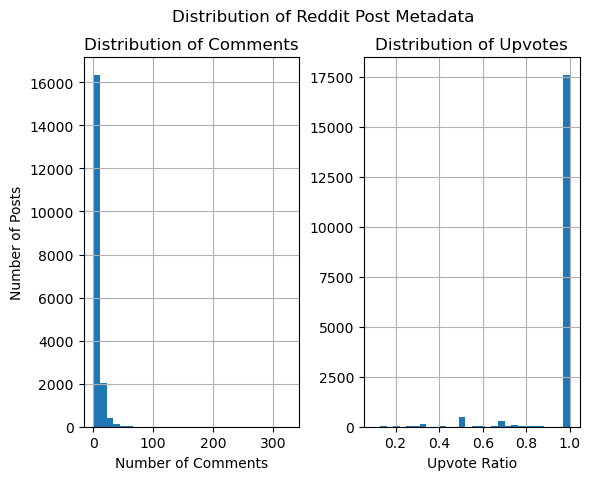

In [292]:
# Plotting the distribution of post metadata such as score,
# comment count, and upvote ratio
axes = reddit_df.hist(bins=30);
axes.flatten()[0].set_xlabel('Number of Comments');
axes.flatten()[0].set_ylabel('Number of Posts');
axes.flatten()[0].set_title('Distribution of Comments');
axes.flatten()[1].set_xlabel('Upvote Ratio');
axes.flatten()[1].set_title('Distribution of Upvotes');
plt.suptitle('Distribution of Reddit Post Metadata');

In [293]:
# Displaying more exact summary statistics
reddit_df_summary = reddit_df.describe()
reddit_df_summary

,num_comments,upvote_ratio
count,19055.000000,19055.000000
mean,5.775912,0.965486
std,9.361384,0.127805
min,0.000000,0.100000
25%,1.000000,1.000000
50%,4.000000,1.000000
75%,7.000000,1.000000
max,328.000000,1.000000


Looking first at the distribution of comments, we see that the shape of the distribution is as we would expect. Due to the ranking system used by reddit to prioritize certain posts for display, the vast majority of posts have little to no comments unless they are both popular and promoted by reddit's algorithm. For this reason, an exponential distribution like the one shown here is to be expected. However, the upper bounds of the distribution are suspiciously high, with one post having recieved over 50 times the average number of comments. While this is not unreasonable for reddit, it is high enough to be worth inspecting directly.

To do this, we can look at the five most-commented-on posts in the cell below.

In [294]:
# Displaying links to the posts with the highest comment counts
pd.set_option('display.max_colwidth', 100)
reddit_df.sort_values('num_comments', ascending=False).url.head(5)

5604                       https://www.reddit.com/r/playstation/comments/ieale9/50_ps_gift_card_give_away/
6654          https://www.reddit.com/r/playstation/comments/i4zxcj/we_gonna_be_honest_about_state_of_play/
463           https://www.reddit.com/r/playstation/comments/jb19bb/breaking_down_the_party_safety_changes/
2300                                      https://www.reddit.com/r/playstation/comments/iyq6a6/psn_status/
455     https://www.reddit.com/r/playstation/comments/jb1tn2/petition_for_this_update_to_be_reversed_asap/
Name: url, dtype: object

Looking at the above posts, we can see that the post with the most comments recieved so many because it was a giveaway offering a free gift card to a random commentor. By contrast, the next four most commented-on posts were addressing an issue with the software of the playstation and therefore attracted a significant amount of debate and several complaints.

Compared to the other posts that can be found on r/playstation, the giveaway post stands out as an outlier in terms of its text as well as its subject. Including this post in our training data would likely mislead our final model due to the data not being representative of the communities it is attempting to distinguish between. For that reason, it would benefit our model if it were removed from the dataset.

In [295]:
# Dropping outlier post
reddit_df = reddit_df.drop(5604)

With outliers in comments addressed, we can continue our analysis by looking at upvotes. Like with comments, the distribution of upvotes within the subreddit is as we would expect. When faced with a post they dislike, most redditors will choose to simply not interact with it rather than give it a downvote. Since many individuals will only downvote a post they feel strongly about, we would expect the vast majority of posts to have an upvote-to-downvote proportion of 1. 

However, some posts on the subreddit score exceptionally poorly, being more than five standard deviations below the mean of upvotes. With such suspiciously low scores, it is possible that these posts could be off-topic or bot posts that would mislead our model. For this reason, it is worth inspecting these posts, given in the cell below.

In [296]:
# Displaying links to the posts with the lowest upvote ratios
pd.set_option('display.max_colwidth', 100)
reddit_df.sort_values('upvote_ratio', ascending=True).url.head(5)

3209    https://www.reddit.com/r/xbox/comments/iskbpn/xbox_one_x_titles_will_not_run_on_the_series_s/
9710     https://www.reddit.com/r/playstation/comments/hhj4qd/witch_mothergucker_made_psplus_a_thing/
7388    https://www.reddit.com/r/xbox/comments/hr7vk8/why_do_i_have_to_insert_game_disc_every_time_i/
7889      https://www.reddit.com/r/xbox/comments/hl7lih/will_xbox_stop_being_political_any_time_soon/
7758                    https://www.reddit.com/r/playstation/comments/hxcoi0/avowedanything_bethesda/
Name: url, dtype: object

While these posts are peculiar, we can see that the majority of them are on-topic, human-made posts. It appears that these posts have been downvoted not for irrelevancy but for being unpopular and/or confrontational. Given that unpopular posts are a relevant part of each community's overall discussions, we want our model to be able to train on them. Thus, there is no reason to remove them from our dataset.

Finally, we must inspect the distribution of data between our two subreddits of interest. When training a classifier model to be able to distinguish between two groups, it is important to make sure that one group does not have significantly more entries in your dataset than another. Groups that are highly underrepresented in training datasets are often not properly learned by models, resulting in biased classifiers that can accurately predict groups that were prevalent in the dataset but that struggle when given examples from groups that were not.

To ensure that this does not happen to our subreddit model, we can inspect the number of posts from each subreddit in our dataset.

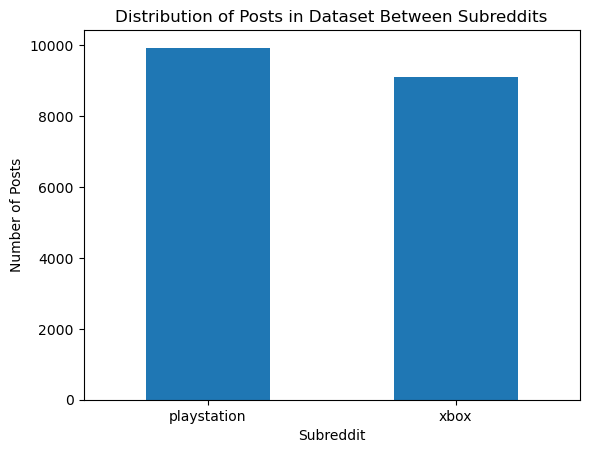

In [297]:
# Plotting the proportion of posts from each subreddit
reddit_df['subreddit'].value_counts().plot(kind='bar', rot=0);
plt.title('Distribution of Posts in Dataset Between Subreddits');
plt.xlabel('Subreddit');
plt.ylabel('Number of Posts');

In this plot, we can see that our cleaned dataset has a nearly identical number of posts from both subreddits. Since there is no large difference in data for each subreddit, there is no need to trim or pad the dataset to reduce model errors.

## Data Preparation

### Combining Text Data

With our dataset now cleaned of `NaN`s and outliers, we can perform an additional step to increase the amount of text data available for our future model training. Since both the `title` and `selftext` columns contain meaningful text data from each subreddit that can help train our model, we can combine them into a single column containing the text from both in order to consolidate our training data.

In [298]:
# Combining title and selftest columns
reddit_df['text'] = reddit_df.title + " " + reddit_df.selftext

### Splitting the Dataset

Now that our data has been cleaned and consolidated, we can begin preparing the data for use in model training by converting it into the format expected by our future classifier model.

We will begin by splitting our data into training, testing, feature, and target sets

In [299]:
# Splitting data into train and test sets as well as feature and target sets 
X_train, X_test, y_train, y_test = train_test_split(reddit_df[['text']], reddit_df[['subreddit']])

### Text Trimming

In order to train our subreddit classifier, our data needs to be simplified and trimmed of any words that aren't useful for our training. Human-made writing often includes many words and characters that contain little meaning in and of themselves and serve only to maintain the grammar and syntax of the sentence. Our subreddit classifier will not see any meaningful connection between these words and the subreddits they were written in. Therefore, they have the potential to negatively impact our model's predictions.

In order to combat this, we can attempt to remove conjugation, punctuation and meaningless words, also known as stop words. To accomplish this, we will convert the subreddit posts in our dataset into collections of token objects that contain the meaning of each word in the original post.

In [300]:
# Converting text data to SpaCy doc objects
# Note: This step is time consuming
nlp = spacy.load('en_core_web_md')
# nlp.add_pipe("merge_noun_chunks")
X_train_nlp = X_train.applymap(nlp)
X_test_nlp = X_test.applymap(nlp)

Now that we have converted our posts into collections of tokens, we can perform a series of steps to remove clutter from the text. First, we can selectively remove word and character tokens that will not help us predict the subreddit they came from. Once this is done, we will be left with only words that have meaning in and of themselves.

However, we will still have various different versions of each word, altered to suit the grammar of the sentence they were in. For the purposes of our model the words 'play', 'playing', and 'played' all hold the same meaning. To ensure that the model views these words as the same, we can either remove all suffixes attached to words (a process known as stemming) or attempt to convert them into the base form of the word (a process known as lemmatization).

Since our model is ultimately meant to tell both us and the users of reddit what topics can be used to distinguish between the two subreddits, it would be preferable to use lemmatization rather than stemming on our dataset, since stemmed words are often more difficult to read and interpret.

After removing punctuation, eliminating stop words, and lemmatizing relevant words we can convert our collection of tokens back into normal strings of text for further processing. All these natural language processing steps are performed in the subsequent two cells.

In [301]:
def get_relevant_words(doc):
    '''
    This function creates a string of lemmas in a SpaCy doc that are
    not stop words or punctuation, in the order that they appeared.
    
    Parameters
    ----------
    doc: A SpaCy doc object
    
    Returns
    -------
    A string that contain non-stop, non-puntuation, lemmatized words
    '''
    return " ".join([token.lemma_ for token in doc if (not token.is_stop) and (not token.is_punct)])

In [302]:
# Convert training features into strings of relevant words
X_train_lemmas = X_train_nlp.applymap(get_relevant_words).text

With this, we have simplified the text in each reddit post down into its most meaningful components and captured the information that our future classifier will train on.

However, we still need to transform these words into a format that our models can use. For each word in our text data, we need to create a column that encodes the frequency of the word in each reddit post in our dataset. This numeric representation of each word's presence in our text data will allow our models to understand the contents of our reddit posts.

When making this conversion, we have the option of presenting each word in our posts on their own (known as monograms) or in ordered pairs (known as bigrams). Bigrams can add additional information to our model since, occasionally, two words together can hold a different meaning than two words apart, such as with 'high' and 'score'. However, the inclusion of bigrams in our numeric dataset would introduce a crippling flaw into our future model.

In order to prevent our model from overfitting to the small sample of posts we have available to us, it is important to make sure that we do not provide it with too many columns of data to train on. When numerically encoding our data as monograms, we end up with approximately 18,000 columns in our dataset. One for each unique word. This numeric representation already has nearly as many columns and our dataset has rows. Were we to numerically represent our data as monograms _and_ bigrams, our dataset would end up with far too high a ratio of features to entries and our model would end up overfitting severly enough to be completely unusable. In order to avoid this issue, we will be numerically representing our data as monograms only.

The following two cells perform this conversion.

In [303]:
# Vectorize our reddit dataset and store it as a DataFrame
tfidf = TfidfVectorizer()
X_train_nlp_sparse = tfidf.fit_transform(X_train_lemmas)
X_train_tfidf = pd.DataFrame(X_train_nlp_sparse.todense(), columns=tfidf.get_feature_names_out())

In [304]:
# Repeating nlp for testing dataset
X_test_nlp_sparse = tfidf.transform(X_test_nlp.applymap(get_relevant_words).text)
X_test_tfidf = pd.DataFrame(X_test_nlp_sparse.todense(), columns=tfidf.get_feature_names_out())

### Removing Self-Referential Terms

Now that our data has been vectorized into a numeric format, it is nearly ready to be used for model training. However, before doing so, there is one last problem in the dataset that must be addressed.

This problem can be seen by looking at the most common words in the dataset

In [305]:
X_train_tfidf.sum().sort_values(ascending=False).head(10)

game          738.110022
xbox          700.817730
play          410.030709
ps4           397.994336
account       349.712526
buy           343.962339
ps5           335.101927
know          308.857253
controller    293.082969
try           285.206887
dtype: float64

In this list of most common words, we can see that the posts in our dataset frequently reference the name of the subreddit itself. This self-referential behavior would theoretically be beneficial for our future classifier model, as it would be able to easily distinguish between each subreddit's posts based on whether or not it was explicitly named.

However, the purpose of our model is not merely to distinguish between the two subreddits, but to identify the topics of discussion _other than consoles_ that distinguish these two communities. If these self-referential terms are left in the dataset, our final model will fail to identify any underlying topics of discussion in either subreddit and will instead simply learn to search for these terms.

In order to force our model to learn to distinguish between these subreddits based solely on discussion topic, we should remove any words in our dataset that explicitly name the console the subreddit is about.

In [306]:
# Dropping self-referential words from the vectorized feature data
self_referential_words = ['ps','ps1','ps2','ps3','ps4','ps5','playstation','xbox','360','series','xsx']
X_train_tfidf = X_train_tfidf.drop(self_referential_words, axis=1)
X_test_tfidf = X_test_tfidf.drop(self_referential_words, axis=1)

And with that, our datasets are now ready to be saved and used in the training of models that can differentiate between these two subreddits and identify the deeper differences between their communities.

In [307]:
# Saving vectorized feature data and separated target data
X_train_tfidf.to_csv('../datasets/X_train_tfidf.csv')
X_test_tfidf.to_csv('../datasets/X_test_tfidf.csv')
y_train.to_csv('../datasets/y_train.csv')
y_test.to_csv('../datasets/y_test.csv')